# Capse.jl chains
In this notebook we will show how to use the Capse.jl emulator in combination with Turing.jl, performing a ACTPolLite analysis. In particolar, we are gonna show:

- How to compute the Maximum A Posteriori (MAP), using the L-BFGS method provided by Optim.jl
- How to use Pathfinder.jl to obtain a quick posterior estimate and initialize chains
- How to use NUTS and MicroCanonical Hamiltonian MonteCarlo as sampling algorithms

Let us start initializing the Julia environment. This will download and install the precise version of the required packages.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

  Activating project at `~/Desktop/papers/capse_paper/standard_emulator`
Precompiling project...
  ✓ WeakRefStrings
  ✓ CSV
  ✓ Latexify → DataFramesExt
  ✓ MicroCanonicalHMC
  ✓ Plots
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ StatsPlots
  8 dependencies successfully precompiled in 114 seconds. 377 already precompiled.
  No Changes to `~/Desktop/papers/capse_paper/standard_emulator/Project.toml`
  No Changes to `~/Desktop/papers/capse_paper/standard_emulator/Manifest.toml`


In [2]:
using Statistics
using SimpleChains
using NPZ
using Turing
using Optim
using Pathfinder
using StatsPlots
using Capse
using BenchmarkTools
using LinearAlgebra
using NPZ
using Transducers
using ACTPolLite
import MCMCChains: compute_duration
using MicroCanonicalHMC
using MCMCDiagnosticTools
using DataFrames
include("utils.jl")

[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
[ Info: Precompiling Pathfinder [b1d3bc72-d0e7-4279-b92f-7fa5d6d2d454]
[ Info: Precompiling OptimizationTrackerExt [6f925a2f-d401-5292-b03c-02bdce8cac1c]
[ Info: Precompiling PathfinderTuringExt [c1ef0224-be37-5956-88ca-b627de78d0fe]
[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


extract_single (generic function with 1 method)

Here we initialize the neural network we use for the emulator.
Do not modify this cell!

In [3]:
mlpd = SimpleChain(
  static(6),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(identity, 4999)
);

After creating the neural network, we initialize our emulators.

In [4]:
weights_folder = "../weights/weights_cosmopowerspace_10000/"
ℓ = npzread(weights_folder*"l.npy")

weights_TT = npzread(weights_folder*"weights_TT_lcdm.npy")
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TT)
CℓTT_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TT, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTT_lcdm.npy"));

In [5]:
weights_EE = npzread(weights_folder*"weights_EE_lcdm.npy")
trained_emu_EE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_EE)
CℓEE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_EE, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓEE_lcdm.npy"));

In [6]:
weights_TE = npzread(weights_folder*"weights_TE_lcdm.npy")
trained_emu_TE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TE)
CℓTE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TE, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTE_lcdm.npy"));

In [7]:
weights_PP = npzread(weights_folder*"weights_PP_lcdm.npy")
trained_emu_PP = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_PP)
CℓPP_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_PP, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓPP_lcdm.npy"));

## ACTPolLite & Turing

Here we are going tyo create some functions to analyze ACTPol data.
The first function, given a list of arguments, retrieves the binned $C_\ell$'s 

In [8]:
ls = 2:5000
fac=ls.*(ls.+1)./(2*π)

function call_emu_actpol(θ, Emu_TT, Emu_TE, Emu_EE, fac)
    return Capse.get_Cℓ(θ, Emu_TT)./fac, Capse.get_Cℓ(θ, Emu_TE)./fac, Capse.get_Cℓ(θ, Emu_EE)./fac
end

call_emu_actpol (generic function with 1 method)

This other function is a closure, defining a more manageable version of the same function (in this way we don't have to pass some fixed arguments)

In [9]:
theory_actpol(θ) = call_emu_actpol(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu, fac)

theory_actpol (generic function with 1 method)

In [10]:
x = rand(6)
@benchmark theory_actpol($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  107.295 μs …  2.248 ms  ┊ GC (min … max): 0.00% … 91.40%
 Time  (median):     119.213 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   127.140 μs ± 98.096 μs  ┊ GC (mean ± σ):  3.54% ±  4.35%

        ▂▄▆▇█▇▇▇▆▆▅▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▁                    ▂
  ▂▄▄▆▅▇█████████████████████████████████████▇▇▇▇▇▆▇▆▅▆▆▅▆▅▆▅▅ █
  107 μs        Histogram: log(frequency) by time       164 μs <

 Memory estimate: 353.84 KiB, allocs estimate: 46.

Since the Covariance matrix we are gonna use does not depend on the model parameters, we can define the following quantities

$\Gamma = \mathrm{sqrt}(\Lambda)$

$i\Gamma=\mathrm{inv}(\Gamma)$

$D = i\Gamma \cdot d$

We can now sample a MvNormal with an easier covariance matrix

$D \sim \mathrm{MvNormal}(i\Gamma\cdot t(\theta), I)$

The advantage of this reparametrization is that we compute the inverse of a matrix just once and not at every step of the MCMC, without resoirting to any approximation: the two likelihood defined are mathematically equivalent.

In [11]:
Γ = sqrt(ACTPolLite.cov_ACT)
iΓ = inv(Γ)
D = iΓ * ACTPolLite.data;

Although this is a bit different from the way we are used to code likelihoods in cosmology, it is easy to explain how to use a Probabilistic Programming Language (PPL) such as Turing.

When we use the "$\sim$" symbol, we are saying that the left-hand-side is sampled from the distribution on the right-hand-side

In [12]:
@model function CMB_ACTPol(D, iΓ, WF)
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.065, 0.015)
    yₚ     ~ Uniform(0.9, 1.1)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    tt, te, ee = theory_actpol(θ)

    te .*= yₚ
    ee .*= yₚ^2
    
    X_model = iΓ * ACTPolLite.compone_window_Cℓ(tt, te, ee, WF)
    
    D ~ MvNormal(X_model, I)
end

CMB_ACTPol_model = CMB_ACTPol(D, iΓ, ACTPolLite.WF)

DynamicPPL.Model{typeof(CMB_ACTPol), (:D, :iΓ, :WF), (), (), Tuple{Vector{Float64}, Matrix{Float64}, ACTPolLite.WindowFunction}, Tuple{}, DynamicPPL.DefaultContext}(CMB_ACTPol, (D = [14.205163574582478, 15.30450143336489, 14.56564669095626, 16.763718445804457, 17.05254865673962, 16.684724229109758, 17.452344541673025, 16.928490212520057, 14.640608110250994, 17.531181362696884  …  1.829926717495442, 2.93882261277649, 0.9932290154920781, -0.5676077518248538, -0.8833722892840291, 1.3437306697752764, -0.9295339091838362, -0.3300207789293402, -2.047112217043857, 1.9987987251210189], iΓ = [326.14982693005754 31.336951058849 … -1.7281563505028354 0.1899904418975723; 31.336951058849003 484.21856239540347 … -1.7485633339100106 -0.8733716389720488; … ; -1.7281563505028361 -1.7485633339100104 … 1.2505242271575176e6 31639.628206689795; 0.1899904418975724 -0.8733716389720484 … 31639.628206689795 1.1463485606934512e6], WF = ACTPolLite.WindowFunction([3.2265368598882327e-7 4.3049057544775417e-7 … -9.

Let us perform the MAP computation. Turing has been interfaced with Optim, which provides some powerful minimization methods such as L-BFGS.

In [13]:
bestfit_ACTPol = optimize(CMB_ACTPol_model, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
@benchmark optimize(CMB_ACTPol_model, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

┌ Warning: #= /home/marcobonici/.julia/packages/ACTPolLite/sD4eR/src/ACTPolLite.jl:75 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ ACTPolLite ~/.julia/packages/LoopVectorization/91gMc/src/condense_loopset.jl:1148


BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  500.387 ms … 967.223 ms  ┊ GC (min … max): 1.52% … 1.11%
 Time  (median):     611.335 ms               ┊ GC (median):    1.74%
 Time  (mean ± σ):   675.261 ms ± 159.835 ms  ┊ GC (mean ± σ):  1.48% ± 0.30%

  █     █   █ █   █             █             █               █  
  █▁▁▁▁▁█▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  500 ms           Histogram: frequency by time          967 ms <

 Memory estimate: 314.01 MiB, allocs estimate: 18669.

The minimization takes less than half a second!

We are going to run 6 parallel chains, with 500 adaptation steps and 5'000 steps (note that Turing will not retrieve the burn-in steps)

In [14]:
nsteps = 5000
nadapts = 500
nchains = 6

6

Before starting chains, let us use Pathfinder. This will deliver an approximation to the posterior

In [15]:
result_multi = multipathfinder(CMB_ACTPol_model, 5000; nruns=8, executor=Transducers.PreferParallel())

┌ Warning: 2 (1.0%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (1.1%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.4%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.8%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (1.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

Multi-path Pathfinder result
  runs: 8
  draws: 5000
  Pareto shape diagnostic: 0.9 (bad)

In [16]:
@time multipathfinder(CMB_ACTPol_model, 5000; nruns=8, executor=Transducers.PreferParallel())

┌ Warning: 1 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.4%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.8%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.8%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.4%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

 13.545718 seconds (3.89 M allocations: 20.423 GiB, 3.38% gc time)


Multi-path Pathfinder result
  runs: 8
  draws: 5000
  Pareto shape diagnostic: 0.78 (bad)

In [17]:
result_multi.draws_transformed

Chains MCMC chain (5000×7×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

      ln10As    0.3049    0.0030     0.0000    0.0000   4930.6614    0.9999
          ns    1.0116    0.0128     0.0002    0.0002   5065.4883    0.9998
          h0    0.6829    0.0121     0.0002    0.0002   4849.3117    0.9999
          ωb    0.2148    0.0030     0.0000    0.0000   5144.5837    1.0000
          ωc    0.1168    0.0028     0.0000    0.0000   4926.0528    0.9998
           τ    0.0654    0.0134     0.0002    0.0002   4944.6431    0.9999
          yₚ    1.0014    0.0042     0.0001    0.0001   4607.1350    0.9999

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64 

In [18]:
chain_actpol_PF = combine_chains(result_multi.draws_transformed)
npzwrite("chains_ACT_PF.npy", chain_actpol_PF)

Pathfinder is incredibly fast: it performed the analysis in as few as 15 seconds. However, it is an approximate method. Although it might not always used to give a faithful approximation of the posteriori, it is very useful in starting the chains as close as possible to the typical set.

Here we are gonna use some Pathfinder draws to initialize our chains.

In [19]:
init_params = collect.(eachrow(result_multi.draws_transformed.value[1:nchains, :, 1]));

Let us now start the NUTS chains.

In [20]:
chains_actpol_nuts = sample(CMB_ACTPol_model, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params)

┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:03:57


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 1832.59 seconds
Compute duration  = 10178.31 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3047    0.0030     0.0000    0.0000   17444.5865    1.0000   ⋯
          ns    1.0104    0.0154     0.0001    0.0001   16961.8640    1.0002   ⋯
          h0    0.6830    0.0151     0.0001    0.0001   14103.5665    1.0001   ⋯
          ωb    0.2155    0.0031     0.0000    0.0000   23593.8106    0.9999   ⋯
          ωc    0.1168    0.0037     0

Let us plot our chains. As we can see, the samples looks almost uncorrelated, which is consistent with our estimate of the correlation length, which is between 2-3 for cosmological parameters.

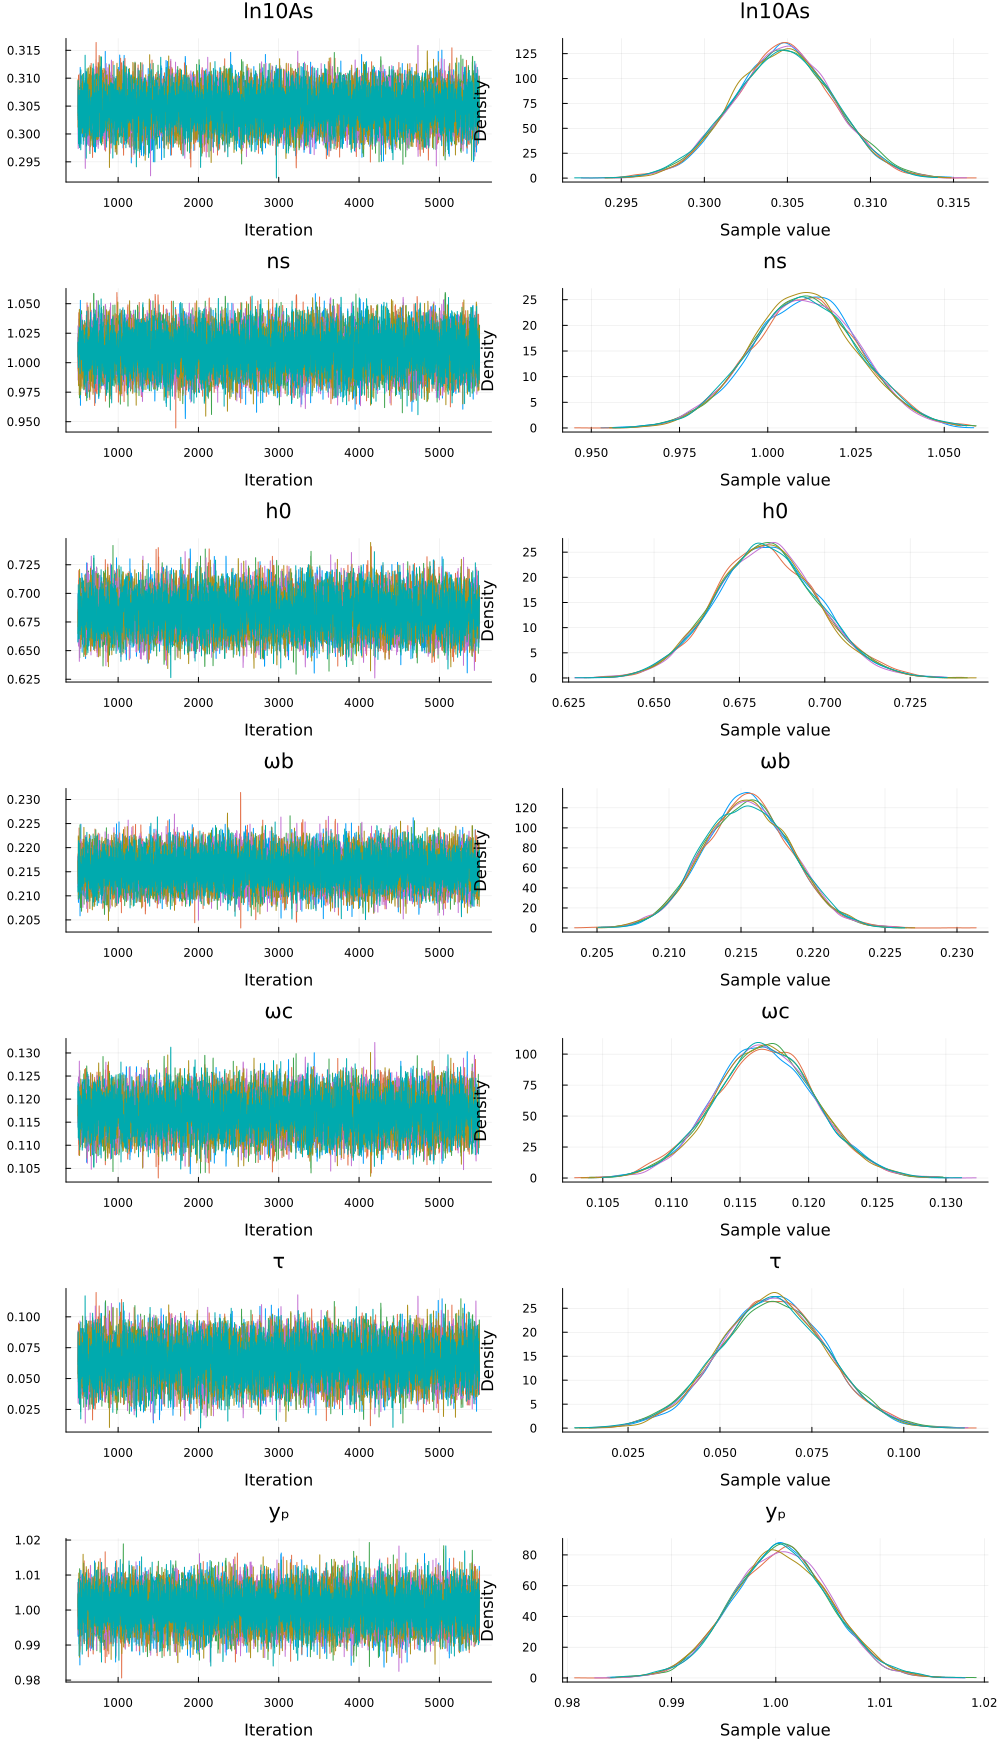

In [25]:
p = StatsPlots.plot(chains_actpol_nuts)
StatsPlots.savefig("traceplots_ACT.png")
p

In [22]:
chain_act = combine_chains(chains_actpol_nuts)
#ln10As = chain_planck[:,1]
#ns = chain_planck[:,2]
#H0 = chain_planck[:,3]
#omb = chain_planck[:,4]
#omc = chain_planck[:,5]
#tau = chain_planck[:,6];
npzwrite("chains_ACT_NUTS.npy", chain_act)

In [23]:
#planck_hmc_ln10As = 10 .* vec(chains_planck_nuts["ln10As"])
#planck_hmc_ns = vec(chains_planck_nuts["ns"])
#planck_hmc_H0 = 100 .* vec(chains_planck_nuts["h0"]) 
#planck_hmc_ωb = 0.1 .* vec(chains_planck_nuts["ωb"])
#planck_hmc_ωc = vec(chains_planck_nuts["ωc"])
#planck_hmc_τ = vec(chains_planck_nuts["τ"])
#planck_hmc_yₚ = vec(chains_planck_nuts["yₚ"]);

An interesting quantity we will compare with the MCHMC run is the ESS per second

In [26]:
CPU_s_ACTPol_NUTS = compute_duration(chains_actpol_nuts)
ACTPol_NUTS_ESS = mean(MCMCDiagnosticTools.ess_rhat(chains_actpol_nuts)[[:ln10As, :ns, :h0, :ωb,:ωc, :τ, :yₚ],:ess])
ACTPol_NUTS_ESS_s = ACTPol_NUTS_ESS/CPU_s_ACTPol_NUTS

1.7908815033153653

An ESS/s of 1.6 means that we can reach the (heuristic) threshold of 400 ESS in around 4 minutes and, taking advantage of the multiple processor, our analysis can be performed in around 1 minute.

## The MicroCanonical Hamiltonian MonteCarlo sampler
Here we will use the Julia implementation of the MCHMC sampler.
We will use 20'000 adaptation steps (that will be discarded) and 200'000 steps.

In [38]:
d = 7
target = TuringTarget(CMB_ACTPol_model)
nadapts = 20_000
nsteps = 200_000
spl = MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d),# sigma=ones(d),
            adaptive=true)
@time actpol_mchmc = Sample(spl, target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_ACTPol.values.array)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:13

Burn in step: 4000
eps --->0.00415145585735993


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:56

Burn in step: 8000
eps --->0.09506600542075577


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:37

Burn in step: 12000
eps --->0.14022122619117508


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.17364536422395474


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:33

Burn in step: 20000
eps --->0.14716495481910769


[ Info: eps: 0.14716495481910769
[ Info: L: 2.6457513110645907
[ Info: nu: 0.12965343823525885
[ Info: sigma: [0.1147155085907416, 0.5094098652913991, 0.3945990779575386, 0.291650317136007, 0.17296006111427267, 0.01343618382507515, 0.28697123922111145]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:39

1034.686434 seconds (75.35 M allocations: 630.662 GiB, 2.51% gc time)


200000-element Vector{Any}:
 [0.3050977417067128, 1.0348698622069834, 0.706289077545354, 0.21598408468780625, 0.11274447627170772, 0.07691006835921466, 0.9983996227354701, 0.14716495481910769, 0.1703176074155408, -392.8642666395003]
 [0.30514833916288975, 1.0340918653996094, 0.7053852635607706, 0.21614086622285716, 0.11238572204973026, 0.07779365429698122, 0.9986215683152472, 0.13920305389825802, -0.2788235734794853, -390.0991959185995]
 [0.3051691295688025, 1.0333818676102347, 0.7037564407137012, 0.21625707252131798, 0.1120587330336612, 0.07821718208954172, 0.9986760778264917, 0.13945513491018877, -0.07166634166162567, -388.40068382340394]
 [0.30523323309614664, 1.0327264671248473, 0.7018295439419718, 0.21631593371303934, 0.11176598530691814, 0.07856982846607187, 0.998740530908202, 0.14031091832619247, 0.01067828759863687, -388.64830339036916]
 [0.3052531386795339, 1.031756446986336, 0.7001287486120582, 0.21642258177955595, 0.11152906594284892, 0.07902438607474697, 0.9986462267717292,

In [31]:
n_parallel_mchmc = 8
chains = Vector{Any}(undef, n_parallel_mchmc)
vec_ess = zeros(n_parallel_mchmc)

nadapts = 20_000
nsteps = 200_000
start_mchmc = time()

@time for i in 1:n_parallel_mchmc
    chains[i] = Sample(MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d), adaptive=true), target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_ACTPol.values.array)
    vec_ess[i] = mean(Summarize(chains[i])[1][1:7])
end

end_mchmc = time()
time_mchmc_parallel_ACTPol = end_mchmc - start_mchmc

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.005132877552316645


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.05501768463837434


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.06364744340655155


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.09464300895361993


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:35

Burn in step: 20000
eps --->0.08889269744562504


[ Info: eps: 0.08889269744562504
[ Info: L: 2.6457513110645907
[ Info: nu: 0.09964629077406258
[ Info: sigma: [0.2695848341502255, 0.4144501578471387, 0.3034124501728613, 0.44809893850147414, 0.27975259675434905, 0.03098457346808076, 0.12870020948482158]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:46[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.0045356371272038745


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.15511688377650523


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.14485309625138687


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.17237535802728707


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:34

Burn in step: 20000
eps --->0.20661015689048984


[ Info: eps: 0.20661015689048984
[ Info: L: 2.6457513110645907
[ Info: nu: 0.15539794448969244
[ Info: sigma: [0.14081376170061297, 0.43323196964181454, 0.30353985898395286, 0.2605320568116944, 0.14785553548124225, 0.015983799737922806, 0.10480391265936463]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:52[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.005815808168603908


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.16033843248422186


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.16708474166072362


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.1902043231757489


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:35

Burn in step: 20000
eps --->0.19115387350364965


[ Info: eps: 0.19115387350364965
[ Info: L: 2.6457513110645907
[ Info: nu: 0.14902552329818286
[ Info: sigma: [0.12126270657729823, 0.6479865271382137, 0.32954952307719115, 0.3281614634626903, 0.1594004448573809, 0.013983832349153033, 0.08981515209664594]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:42[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:15

Burn in step: 4000
eps --->0.0055013070424236605


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.06471347758084019


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.09937060517424673


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.07183787749617342


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:35

Burn in step: 20000
eps --->0.10133496074046712


[ Info: eps: 0.10133496074046712
[ Info: L: 2.6457513110645907
[ Info: nu: 0.10664516440543544
[ Info: sigma: [0.1542344456200017, 0.4775513394633498, 0.4425452262670738, 0.5771967485117099, 0.2523138116651153, 0.019813478584407376, 0.17542699021116048]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:44[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.004163584473414251


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.1075164682023391


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.1316183708117051


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.14463314810004402


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:35

Burn in step: 20000
eps --->0.2005361612767451


[ Info: eps: 0.2005361612767451
[ Info: L: 2.6457513110645907
[ Info: nu: 0.15291654860404796
[ Info: sigma: [0.16818479788850002, 0.5902692728639234, 0.3223497210471986, 0.26822711751190076, 0.14845464121471702, 0.0195488674003071, 0.1613395089538969]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:39[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:15

Burn in step: 4000
eps --->0.004631389152025533


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:56

Burn in step: 8000
eps --->0.11410695019986784


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.11937195838781117


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.1288618907258207


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:34

Burn in step: 20000
eps --->0.11744685855436897


[ Info: eps: 0.11744685855436897
[ Info: L: 2.6457513110645907
[ Info: nu: 0.1151656089770916
[ Info: sigma: [0.13452139866074772, 0.5314301952048792, 0.4060362640928275, 0.33498725688024955, 0.2202287961984748, 0.015685368282168148, 0.151873640581831]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:42[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:15

Burn in step: 4000
eps --->0.004569038589830461


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.11092000468996689


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.14069514146314926


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.10735518426011592


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:34

Burn in step: 20000
eps --->0.1482507019019261


[ Info: eps: 0.1482507019019261
[ Info: L: 2.6457513110645907
[ Info: nu: 0.13015803579669774
[ Info: sigma: [0.15294566818937436, 0.5422125589460018, 0.35801469738779773, 0.3398085374342685, 0.15674831207836926, 0.017728569822804466, 0.08944421689627954]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:42[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.006124855118365078


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.10260529677704437


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.10569390296464166


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.11987941490078392


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:36

Burn in step: 20000
eps --->0.12359234825000025


[ Info: eps: 0.12359234825000025
[ Info: L: 2.6457513110645907
[ Info: nu: 0.11827962529943865
[ Info: sigma: [0.1387641457789078, 0.5138634287636822, 0.4876513172890358, 0.2633628681635191, 0.1892146813022895, 0.014621248801979687, 0.22495235618737372]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:49

8337.997213 seconds (608.91 M allocations: 4.974 TiB, 2.50% gc time)


8338.030637979507

Let us compute the ESS per second of the parallel MCHMC run.

In [39]:
ACTPol_MCHMC_parallel_ESS_s = sum(vec_ess)/time_mchmc_parallel_ACTPol

3.9841604493262386

This is higher by a factor of 2.5 than the NUTS ESS/s!

In [36]:
_chains = zeros(nsteps, n_parallel_mchmc, 7)
for i in 1:n_parallel_mchmc
    _chains[:,i,:] = mapreduce(permutedims, vcat, chains[i])[:,1:7]
end

In [41]:
actpol_mchmc = mapreduce(permutedims, vcat, actpol_mchmc)
E = actpol_mchmc[:, end-1]
std(E).^2/d

0.0010394556058201236

In [42]:
x = [mapreduce(permutedims, vcat, chains[i]) for i in 1:n_parallel_mchmc]

actpol_mchmc_multi_chains = zeros(nsteps*n_parallel_mchmc, 7)
for i in 1:7
    actpol_mchmc_multi_chains[:,i] = extract_single(x, i, n_parallel_mchmc)
end

In [43]:
npzwrite("chains_ACT_MCHMC.npy", actpol_mchmc)
npzwrite("chains_ACT_MCHMC_multi.npy", actpol_mchmc_multi_chains)